In [1]:
%matplotlib notebook

In [2]:
!pip install plotly
!pip install -U pymoo   

Requirement already up-to-date: pymoo in c:\programdata\anaconda3\lib\site-packages (0.5.0)


In [3]:
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import random as rand
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
from scipy.special import betainc
from scipy.special import gamma
import matplotlib.pyplot as plt
from statistics import NormalDist
import numpy as np
import colorsys
import random
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize
import time

In [4]:
def nsphere_volume_m_20(r, dim):
    return(((np.pi)**(dim/2))*(r**dim)/(gamma(dim/2 + 1)))

def diff_cone_uniforme_opti(rayon, epsilon, c, theta, iterations, dim):
    list_points = []
    count_in_cone = 0
    points_in_cone = []
    count_in_cone_ptrue = 0
    count_not_in_cone_ptrue = 0
    points_in_cone_ptrue = []
    
    for i in range(iterations):
        u = np.random.normal(0,1,dim)  # an array of d normally distributed random variables
        norm= np.sum(u**2) **(0.5)
        r = np.random.random()**(1.0/dim)
        point = r*u/norm
        point = point*rayon
        list_points.append(point)
        z = point[0]
        S = 0
        for i in range(len(point)-1):
            S += point[i + 1]**2
        rho = np.sqrt(S) 
        if (z > c) and (rho <= z*np.tan(theta)):
            count_in_cone +=1
            points_in_cone.append(point)
        
        point[0] = point[0] + epsilon
        z = point[0]
        S = 0
        for i in range(len(point)-1):
            S += point[i + 1]**2
        rho = np.sqrt(S) 
        if (z > c) and (rho <= z*np.tan(theta)):
            count_in_cone_ptrue +=1
            points_in_cone_ptrue.append(point)
        else:
            count_not_in_cone_ptrue += 1
            
    vol_boule = nsphere_volume_m_20(rayon, dim)
    
    p1 = 1 - count_in_cone/iterations
    
    a = (dim + 1)/2
    b = 1/2
    x = 1 - (epsilon/(2*rayon))**2
    Vcap = (1/2) * vol_boule * betainc(a, b, x) #On utilise la fonction beta incomplete de la librairie scipy.
    
    Psn = p1 - 1 + 2*(Vcap/vol_boule)
    

        
           
            
    vol_deplace = vol_boule*(count_not_in_cone_ptrue/iterations)
    
    p_true = vol_deplace/vol_boule
    
    return(p_true - Psn, p_true, Psn)

def diff_par_uniforme_opti(a_, epsilon, rayon, iterations, dim):
    
    list_points = []
    count_in_par = 0
    points_in_par = []
    count_in_par_ptrue = 0
    count_not_in_par_ptrue = 0
    points_in_par_ptrue = []
    
    for i in range(iterations):
        u = np.random.normal(0,1,dim)  # an array of d normally distributed random variables
        norm= np.sum(u**2) **(0.5)
        r = np.random.random()**(1.0/dim)
        point = r*u/norm
        point = point*rayon
        list_points.append(point)
        
        z = point[0]
        S = 0
        for i in range(len(point)-1):
            S += point[i + 1]**2
        rho = np.sqrt(S) 
        if z > 0 and rho**2 < a_*z:
            count_in_par +=1
            points_in_par.append(point)
        
        point[0] = point[0] + epsilon
        z = point[0]
        S = 0
        for i in range(len(point)-1):
            S += point[i + 1]**2
        rho = np.sqrt(S) 
        if z > 0 and rho**2 < a_*z:
            count_in_par_ptrue +=1
            points_in_par_ptrue.append(point)
        else:
            count_not_in_par_ptrue += 1
        
    vol_boule = nsphere_volume_m_20(rayon, dim)
            
    
    p1 = 1 - count_in_par/iterations
    
    a = (dim + 1)/2
    b = 1/2
    x = 1 - (epsilon/(2*rayon))**2
    Vcap = (1/2) * vol_boule * betainc(a, b, x) #On utilise la fonction beta incomplete de la librairie scipy.
    
    Psn = p1 - 1 + 2*(Vcap/vol_boule)
    
        
            
    vol_deplace = vol_boule*(count_not_in_par_ptrue/iterations)
    
    p_true = vol_deplace/vol_boule
    
    return(p_true - Psn, p_true, Psn)

In [74]:
def appartient_S(point, r1, r2, k1, k2, epsilon, dim, S, count_S):
    boule_r1 = 0 
    boule_r2 = 0
    boule_r1_e = 0
    t = False
    
    z = point[0]
    rho = np.linalg.norm(point[1:])
    norme = np.linalg.norm(point)
                           
    if (norme <= r1):
        boule_r1 = 1
        
    if (norme <= r2):
        boule_r2 = 1
        
    point_e = [0]*len(point)
    point_e[0] += epsilon
    diff = np.array(point_e) - np.array(point)
    dist = np.sum(np.power(diff, 2))
    if dist < r1**2:
        boule_r1_e = 1
    
    
    vol_r1 = nsphere_volume_m_20(r1, dim)
    vol_r2 = nsphere_volume_m_20(r2, dim)
    
    if (boule_r2 == 1 and boule_r1 == 0):
        print(str(boule_r1_e) + ' et' + str(k1*(boule_r1) + k2*(boule_r2*vol_r1/vol_r2)))
                  
    if (boule_r1_e <= k1*(boule_r1) + k2*(boule_r2*vol_r1/vol_r2)):
        S.append(point)
        count_S += 1
        t = True
              
    return(S, count_S, t)

def p_rayon_cone(r, theta, iterations, dim):
    
    point_cone = []
    count_in_cone = 0
    for count_loops in range(iterations):
        u = np.random.normal(0,1,dim)
        norm= np.sum(u**2) **(0.5)
        r = np.random.random()**(1.0/dim)
        point = r*u/norm
        point = point*r
        
        z = point[0]
        rho = np.linalg.norm(point[1:])
        if z > 0 and rho <= z*np.tan(theta):
            point_cone.append(point)
            count_in_cone +=1
    p = 1 - count_in_cone/iterations
    
    return p

def p_rayon_par(r, a_, iterations, dim):
    
    point_par = []
    count_in_par = 0
    for count_loops in range(iterations):
        u = np.random.normal(0,1,dim)
        norm= np.sum(u**2) **(0.5)
        r = np.random.random()**(1.0/dim)
        point = r*u/norm
        point = point*r
        
        z = point[0]
        rho = np.linalg.norm(point[1:])
        if z > 0 and rho**2 <= z*a_:
            point_cone.append(point)
            count_in_cone +=1
    p = 1 - count_in_cone/iterations
    
    return p
    
def vol_par_n_dim_3(r1, iterations, epsilon):
    count_in_par = 0
    points_in_par = []
    for count_loops in range(iterations):
        
        x = np.random.uniform(-10, 10)
        y = np.random.uniform(-10, 10)
        z = np.random.uniform(-10, 10)
        
        point = [x, y, z]
        point_e = [0, 0, 0]
        point_e[0] += epsilon
        diff = np.array(point_e) - np.array(point)
        dist = np.sum(np.power(diff, 2))
        
        if dist < r1**2:
            count_in_par += 1
            points_in_par.append(point)
            
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    for point in points_in_par:
        ax.scatter(point[0], point[1], point[2], color = 'orange')

In [55]:
def probs_p1_p2(r1, r2, k1, k2, epsilon, dim, iterations, draw = False):
    if draw and dim ==2:
        fig, ax = plt.subplots()
    liste_r1 = []
    liste_r2 = []
    S_r1 = []
    S_r2 = []
    count_in_s_r1 = 0
    count_in_s_r2 = 0

    #boule r1
    for i in range(iterations):
        
        u = np.random.normal(0,1,dim)  
        norm= np.sum(u**2) **(0.5)
        r = np.random.random()**(1.0/dim)
        point = r*u/norm
        point = point*r1
        liste_r1.append(point)
        
        S_r1, count_in_s_r1, t = appartient_S(point, r1, r2, k1, k2, epsilon, dim, S_r1, count_in_s_r1)
        if t and draw and dim == 2:
            ax.scatter(point[0], point[1], c = 'orange')
        elif draw and dim == 2:
            ax.scatter(point[0], point[1], c = 'red')
        
    p1 = count_in_s_r1 / iterations
    
    
    #boule r2
    for i in range(iterations):
        
        u = np.random.normal(0,1,dim)  
        norm= np.sum(u**2) **(0.5)
        r = np.random.random()**(1.0/dim)
        point = r*u/norm
        point = point*r2
        liste_r2.append(point)
        if draw and dim ==2 :
            ax.scatter(point[0], point[1], c = 'yellow')
            
        S_r2, count_in_s_r2, t = appartient_S(point, r1, r2, k1, k2, epsilon, dim, S_r2, count_in_s_r2)
        if t and draw and dim == 2:
            ax.scatter(point[0], point[1], c = 'blue')
        elif draw and dim == 2:
            ax.scatter(point[0], point[1], c = 'green')
            
    p2 = count_in_s_r2 / iterations
   
    return p1, p2


def plot_3d_k1_k2_var(min_var, max_var, nbre_var, r1, r2, epsilon, theta, dim, iterations):
    
    pas = (max_var - min_var) / nbre_var
    grid_2D = np.mgrid[min_var:max_var:pas, min_var:max_var:pas]
    ks = grid_2D.reshape(2, -1).T
    t = np.linspace(min_var, max_var - pas, nbre_var)
    k1, k2 = np.meshgrid(t, t)
    list_res_1 = []
    list_res_2 = []
    for i in range(len(ks)):
        res = probs_p1_p2_cone(r1, r2, ks[i][0], ks[i][1], epsilon, theta, dim, iterations)
        list_res_1.append(res[0])
        list_res_2.append(res[1])
        print("calcul fait " + str(i))
    true_list_1 = []
    true_list_2 = []
    for i in range(0, nbre_var):
        liste_1 = []
        liste_2 = []
        for j in range(0, nbre_var):
            liste_1.append(list_res_1[i*nbre_var + j])
            liste_2.append(list_res_2[i*nbre_var + j])
        true_list_1.append(liste_1[:])
        true_list_2.append(liste_2[:])
    
    fig_1 = plt.figure(figsize=(10, 10))
    ax_1 = fig_1.gca(projection='3d')
    ax_1.contour3D(k1, k2, true_list_1, 50, cmap = 'autumn')
    ax_1.set_xlabel('variation de k1')
    ax_1.set_ylabel('variation de k2')
    ax_1.set_zlabel('P(B(0, r1) { S)')
    ax_1.set_title('R1 = ' + str(r1) + ', R2 = ' + str(r2) + ', epsilon = '+ str(epsilon))
    
    fig_2 = plt.figure(figsize=(10, 10))
    ax_2 = fig_2.gca(projection='3d')
    ax_2.contour3D(k1, k2, true_list_2, 50, cmap = 'autumn')
    ax_2.set_xlabel('variation de k1')
    ax_2.set_ylabel('variation de k2')
    ax_2.set_zlabel('P(B(0, r2) { S)')
    ax_2.set_title('R1 = ' + str(r1) + ', R2 = ' + str(r2) + ', epsilon = '+ str(epsilon))

calcul fait 0
calcul fait 1
calcul fait 2
calcul fait 3
calcul fait 4
calcul fait 5
calcul fait 6
calcul fait 7
calcul fait 8
calcul fait 9
calcul fait 10
calcul fait 11
calcul fait 12
calcul fait 13
calcul fait 14
calcul fait 15
calcul fait 16
calcul fait 17
calcul fait 18
calcul fait 19
calcul fait 20
calcul fait 21
calcul fait 22
calcul fait 23
calcul fait 24
calcul fait 25
calcul fait 26
calcul fait 27
calcul fait 28
calcul fait 29
calcul fait 30
calcul fait 31
calcul fait 32
calcul fait 33
calcul fait 34
calcul fait 35
calcul fait 36
calcul fait 37
calcul fait 38
calcul fait 39
calcul fait 40
calcul fait 41
calcul fait 42
calcul fait 43
calcul fait 44
calcul fait 45
calcul fait 46
calcul fait 47
calcul fait 48
calcul fait 49
calcul fait 50
calcul fait 51
calcul fait 52
calcul fait 53
calcul fait 54
calcul fait 55
calcul fait 56
calcul fait 57
calcul fait 58
calcul fait 59
calcul fait 60
calcul fait 61
calcul fait 62
calcul fait 63
calcul fait 64
calcul fait 65
calcul fait 66
calcu

<IPython.core.display.Javascript object>


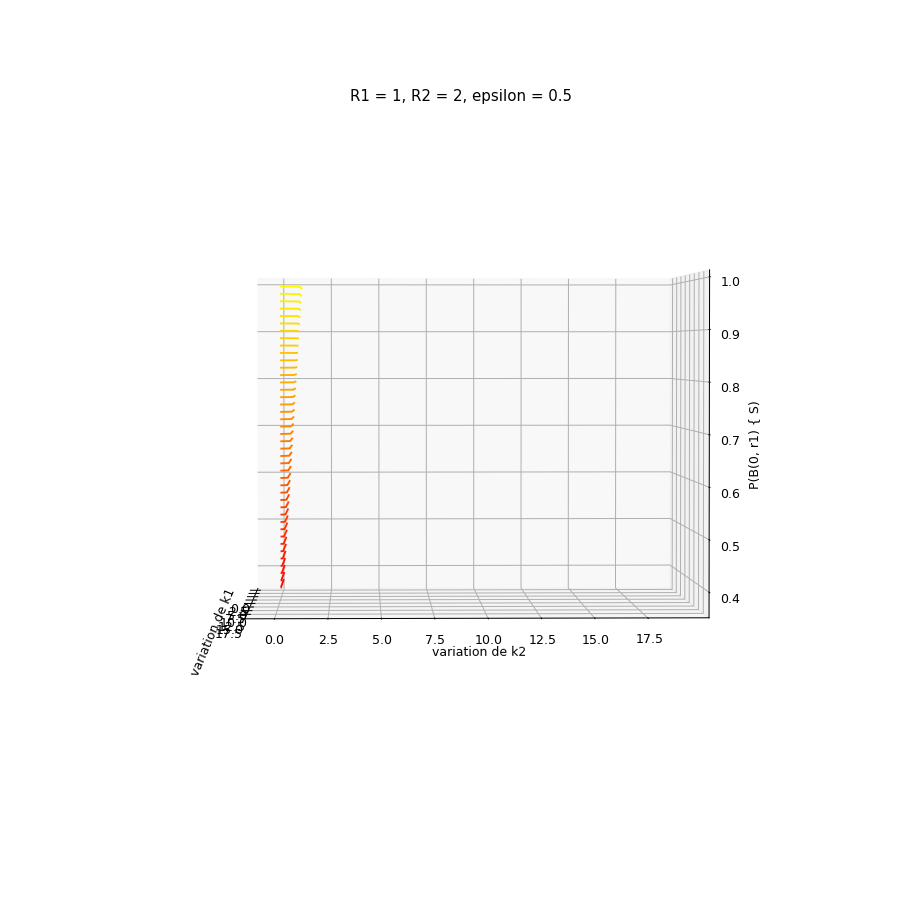

<IPython.core.display.Javascript object>


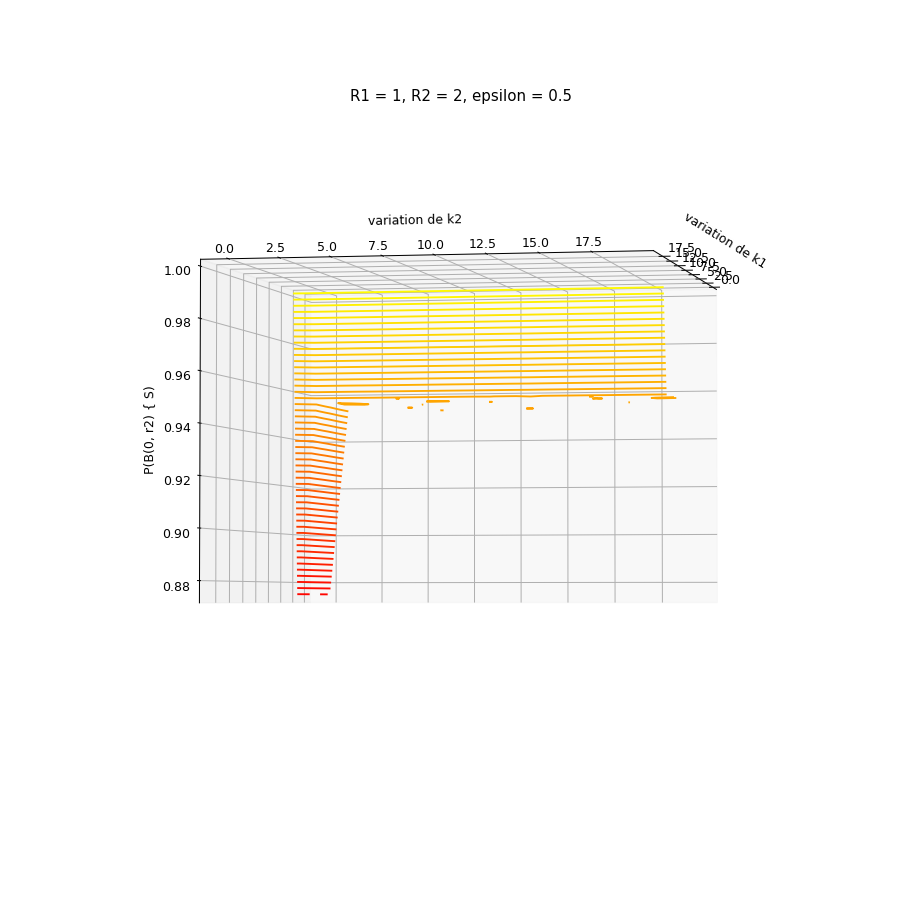

In [15]:
plot_3d_k1_k2_var(0, 20, 20, 1, 2, 0.5, np.pi/4, 3, 100000)

In [7]:
!pip install -U pymoo   

Requirement already up-to-date: pymoo in c:\programdata\anaconda3\lib\site-packages (0.5.0)


In [17]:
!python -c "from pymoo.util.function_loader import is_compiled;print('Compiled Extensions: ', is_compiled())"


Compiled Extensions:  True


In [44]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=2,
                         xl=np.array([0,0]),
                         xu=np.array([100,100]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = p_rayon_cone(1, np.pi/4, 100000, 3) - probs_p1_p2(1, 2, x[0], x[1], 0.5, 3, 100000)[0]
        f2 = p_rayon_cone(2, np.pi/4, 100000, 3) - probs_p1_p2(1, 2, x[0], x[1], 0.5, 3, 100000)[1]

        g1 = -x[0]
        g2 = -x[1]

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


problem = MyProblem()

In [21]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

In [22]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 100)

In [23]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      40 |  0.00000E+00 |  0.00000E+00 |       1 |            - |            -
    2 |      50 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
    3 |      60 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
    4 |      70 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
    5 |      80 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
    6 |      90 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
    7 |     100 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
    8 |     110 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
    9 |     120 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
   10 |     130 |  0.00000E+00 |  0.00000E+00 |       1 |  0.00000E+00 |            f
   11 |     140 |  0.00000E+00 |  0.00000E+00 |       

In [24]:
X

array([[69.44001577, 41.41792695],
       [99.52690822, 69.86148893],
       [17.08830887, 78.62267805],
       [75.07624506, 99.96779459],
       [72.4387341 , 69.86148893],
       [29.76490111, 41.80476411],
       [19.08850615, 78.62267805],
       [73.59840747, 41.41792695],
       [77.21535678, 64.45713839],
       [ 4.52122843, 91.26597762],
       [14.96429108, 98.54591366],
       [ 4.66671881, 96.77347754],
       [74.69258579, 78.68886546],
       [32.74506169, 80.01995687],
       [12.44601949,  8.57257006]])

In [25]:
F

array([[-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05],
       [-1.e-05, -1.e-05]])

In [26]:
for sol in X:
    res = probs_p1_p2_cone(1, 2, sol[0], sol[1], 0.5, np.pi/4, 3, 100000)
    print(p_rayon_cone(1, np.pi/4, 100000, 3) - res[0], p_rayon_cone(2, np.pi/4, 100000, 3) - res[1])

-9.99999999995449e-06 0.0
0.0 0.0
0.0 0.0
-9.99999999995449e-06 0.0
0.0 0.0
-9.99999999995449e-06 0.0
-9.99999999995449e-06 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


In [17]:
for i in range(12):
    print(p_rayon_cone(0.05, np.pi/4, 100000, 3) - p_rayon_cone(2, np.pi/4, 100000, 3))

0.0016299999999999093
0.0012599999999999278
0.00022999999999995246
-0.0021400000000000308
0.0012999999999999678
0.0011700000000000044
0.0016700000000000603
-0.0006099999999999994
4.0000000000040004e-05
-0.0018799999999999928
0.0013799999999999368
0.0016500000000000403


# En plus clean avec pymoo

In [7]:
class Opti_S_cone(ElementwiseProblem):

    def __init__(self, rayons, theta, iterations, epsilon, dimension):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0,0]),
                         xu=np.array([20,20]))
        self.r1 = rayons[0]
        self.r2 = rayons[1]
        self.theta = theta
        self.iterations = iterations
        self.epsilon = epsilon
        self.dimension = dimension
        
        p1 = 0
        p2 = 0
        for i in range(20):
            p1 += p_rayon_cone(self.r1, self.theta, self.iterations, self.dimension)
            p2 += p_rayon_cone(self.r2, self.theta, self.iterations, self.dimension)
        self.p1 = p1/20
        self.p2 = p2/20
        print("Pour ce calcul, on aura p1 = " + str(self.p1) + ', et p2 = ' + str(self.p2) + '.')
        print('')

    def _evaluate(self, x, out, *args, **kwargs):
        res = probs_p1_p2(self.r1, self.r2, x[0], x[1], self.epsilon, self.dimension, self.iterations)
        
        
        f1 = self.p1 - res[0]
        f2 = self.p2 - res[1]
        
        out["F"] = [f1, f2]
        
class Opti_S_par(ElementwiseProblem):

    def __init__(self, rayons, a_, iterations, epsilon, dimension):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0,0]),
                         xu=np.array([20,20]))
        self.r1 = rayons[0]
        self.r2 = rayons[1]
        self.a_ = a_
        self.iterations = iterations
        self.epsilon = epsilon
        self.dimension = dimension
        
        p1 = 0
        p2 = 0
        for i in range(20):
            p1 += p_rayon_par(self.r1, self.theta, self.iterations, self.dimension)
            p2 += p_rayon_par(self.r2, self.theta, self.iterations, self.dimension)
        self.p1 = p1/20
        self.p2 = p2/20
        
        print("Pour ce calcul, on aura p1 = " + str(self.p1) + ', et p2 = ' + str(self.p2) + '.')
        print('')

    def _evaluate(self, x, out, *args, **kwargs):
        res = probs_p1_p2(self.r1, self.r2, x[0], x[1], self.epsilon, self.dimension, self.iterations)
        
        f1 = self.p1 - res[0]
        f2 = self.p2 - res[1]
        
        out["F"] = [f1, f2]


In [8]:
def optim_k1_k2_cone_uniforme_S(r1, r2, epsilon, theta, dim, iterations, gen, verbose_time = False):
    problem = Opti_S_cone([r1, r2], theta, iterations, epsilon, dim)
    
    algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
    )
    
    termination = get_termination("n_gen", gen)
    
    time_1 = time.time()
    res = minimize(problem,
               algorithm,
               termination,
               seed=5,
               save_history=True,
                return_least_infeasible=True,
               verbose=True)
    time_2 = time.time()
    if verbose_time:
        print("Temps de calcul total: " + str(time_2-time_1))
    X = res.X
    F = res.F
    
    
    return X, F

def optim_k1_k2_par_uniforme_S(r1, r2, epsilon, a_, dim, iterations, gen, verbose_time = False):
    problem = Opti_S_par([r1, r2], a_, iterations, epsilon, dim)
    
    algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
    )
    
    termination = get_termination("n_gen", gen)
    
    time_1 = time.time()
    res = minimize(problem,
               algorithm,
               termination,
               seed=5,
               save_history=True,
                return_least_infeasible=True,
               verbose=True)
    time_2 = time.time()
    if verbose_time:
        print("Temps de calcul total: " + str(time_2-time_1))
        
    X = res.X
    F = res.F
    
    
    return X, F

In [11]:
res = optim_k1_k2_cone_uniforme_S(1, 2, 0.5, np.pi/4, 3, 100000, 5, verbose_time = True)

Pour ce calcul, on aura p1 = 0.8538834999999999, et p2 = 0.853411.

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |      23 |            - |            -
    2 |      50 |      32 |  0.00000E+00 |            f
    3 |      60 |      40 |  0.00000E+00 |            f
    4 |      70 |      40 |  0.00000E+00 |            f
    5 |      80 |      40 |  0.00000E+00 |            f
Temps de calcul total: 773.7150340080261


In [12]:
res

(array([[12.79590352, 19.71248806],
        [ 9.76822378, 12.23487726],
        [11.17913906,  9.83108709],
        [13.99687228, 15.91280584],
        [ 0.3529436 ,  9.21920774],
        [12.05577049, 12.63451719],
        [ 1.61482538, 14.76880592],
        [17.53053051, 18.76955   ],
        [17.40966174, 18.45499228],
        [16.21038752, 13.15460882],
        [14.76488193, 11.69391   ],
        [13.99687228, 15.9251239 ],
        [ 5.18195193, 16.04993771],
        [ 0.43505681, 11.55325716],
        [ 0.45866185, 11.55325716],
        [15.65618883, 12.27578745],
        [ 3.30624951, 18.92714628],
        [ 0.45866185,  9.64290293],
        [12.57575818, 11.5967562 ],
        [17.1448721 , 13.77043314],
        [16.33320405, 11.32163992],
        [13.99687228, 15.59029171],
        [16.59982859, 19.2201924 ],
        [ 9.70960923, 15.27136469],
        [12.01444248, 10.30945224],
        [ 0.04428425,  9.38976744],
        [15.31815713, 10.36835976],
        [15.41708174,  9.698

In [22]:
probs_p1_p2(1, 2, res[0][0][0], res[0][0][1], 0.5, 3, 100000)

(1.0, 1.0)

In [11]:
#k1 = k2 = 0
#Proportion des boules r1 et r2 dans la boule B(e, r1)
probs_p1_p2(1, 3, 0, 0, 0.5, 3, 100000)

(0.36444, 0.99901)

1.7777777777777777


<IPython.core.display.Javascript object>


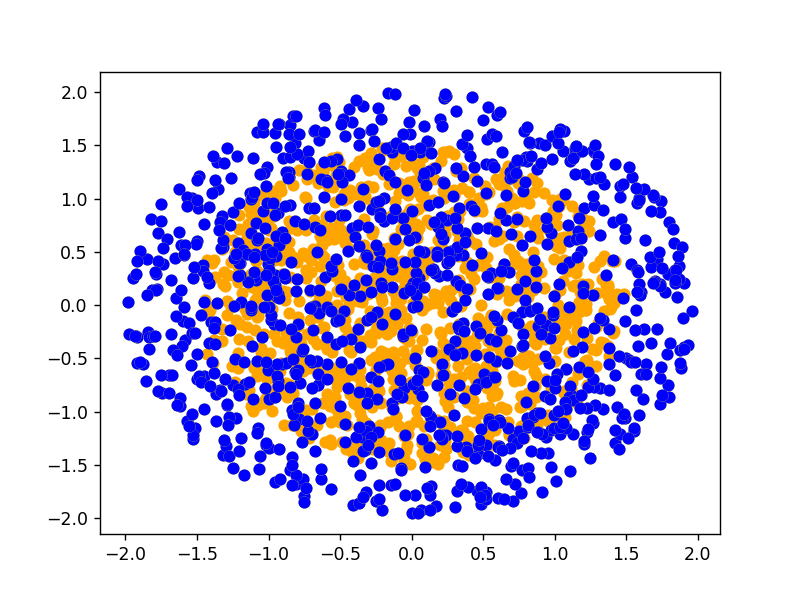

0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
1 et1.0
0 et1.0
1 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
1 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
1 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
1 et1.0
0 et1.0
1 et1.0
1 et1.0
1 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
1 et1.0
1 et1.0
0 et1.0
0 et1.0
1 et1.0
1 et1.0
1 et1.0
1 et1.0
0 et1.0
0 et1.0
1 et1.0
1 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0
0 et1.0
0 et1.0
0 et1.0
1 et1.0


(1.0, 1.0)

In [76]:
#k1 = 1, k2 = 0
vol_r1 = nsphere_volume_m_20(1.5, 2)
vol_r2 = nsphere_volume_m_20(2, 2)
print(1/(vol_r1/vol_r2))
probs_p1_p2(1.5, 2, 1, vol_r2/vol_r1, 0.5, 2, 1000, True)